# Определение рыночной стоимости автомобилей

**Заказчик:** сервис по продаже автомобилей с пробегом «Не бит, не крашен».
Компания разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 
**Задача:** построить модель машинного обучения для определения рыночной стоимости авто

Предоставлены исторические данные об авто: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.


**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV 

pd.options.mode.chained_assignment = None


In [22]:
!pip install lightgbm
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.6 MB/s eta 0:00:00


In [23]:
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost as cb
from catboost import CatBoostRegressor

In [4]:
data.shape

(354369, 16)

In [3]:
data = pd.read_csv ('https://code.s3.yandex.net/datasets/autos.csv')
data = data.rename(columns=str.lower)
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# исправление столбцов с датами на необходимый формат 
data ['datecrawled'] = pd.to_datetime(data['datecrawled'], format="%Y-%m-%d %H:%M:%S")
data ['datecreated'] = pd.to_datetime(data['datecreated'], format="%Y-%m-%d %H:%M:%S")
data ['lastseen'] = pd.to_datetime(data['lastseen'], format="%Y-%m-%d %H:%M:%S")

In [7]:
data.isna().mean().sort_values(ascending=False)

repaired             0.200791
vehicletype          0.105794
fueltype             0.092827
gearbox              0.055967
model                0.055606
datecrawled          0.000000
price                0.000000
registrationyear     0.000000
power                0.000000
kilometer            0.000000
registrationmonth    0.000000
brand                0.000000
datecreated          0.000000
numberofpictures     0.000000
postalcode           0.000000
lastseen             0.000000
dtype: float64

**Пропуски в данных:**

- столбец repaired - 20.1% пропусков
- столбец vehicletype - 10.6%
- столбец fueltype - 9.3%
- столбец gearbox - 5.6%
- столбец model - 5.6%

In [8]:
# для дальнейшей визуализации 
month_datecrawled = data['datecrawled'].dt.month
month_datecrawled = month_datecrawled.to_frame()
print("Уникальных значений month_datecrawled", month_datecrawled.datecrawled.nunique())

month_datecreated = data['datecreated'].dt.month
month_datecreated = month_datecreated.to_frame()
print("Уникальных значений month_datecreated", month_datecreated.datecreated.nunique())

month_lastseen = data['lastseen'].dt.month
month_lastseen = month_lastseen.to_frame()
print("Уникальных значений month_lastseen", month_lastseen.lastseen.nunique())

Уникальных значений month_datecrawled 2
Уникальных значений month_datecreated 9
Уникальных значений month_lastseen 2


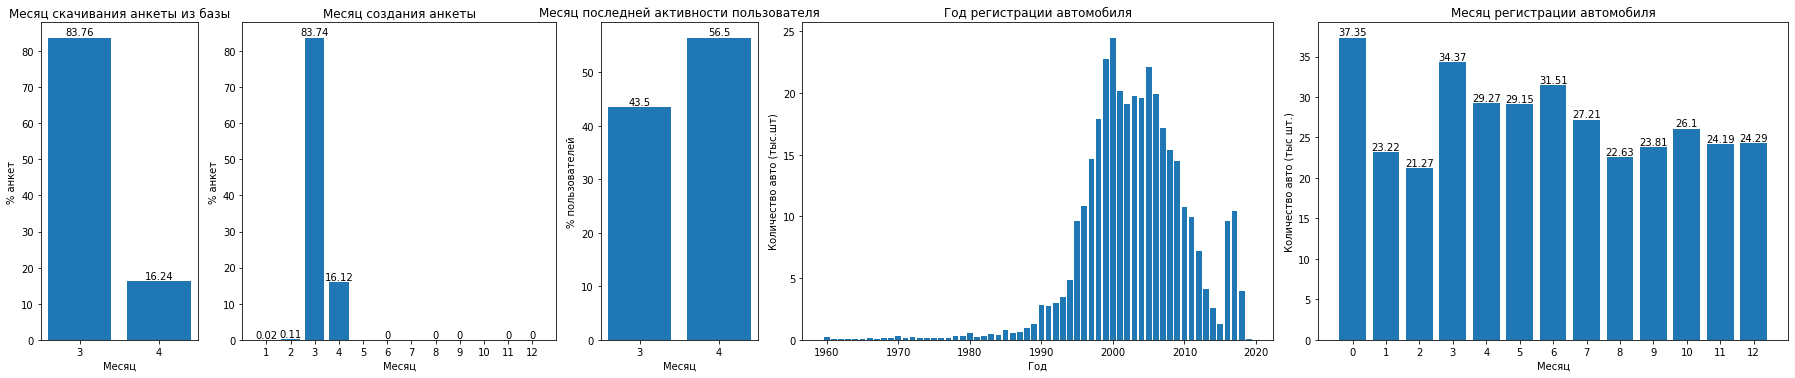

In [9]:
fig, ax = plt.subplots(1,5, gridspec_kw={'width_ratios': [1, 2, 1, 3, 3]}, figsize=(25,5))
fig.tight_layout()

ax[0].bar(month_datecrawled.datecrawled.value_counts(normalize=True).reset_index()['index'], 
          round((month_datecrawled.datecrawled.value_counts(normalize=True)*100),2).reset_index()['datecrawled'])
ax[0].set_title('Месяц скачивания анкеты из базы')
ax[0].set_xlabel('Месяц')
ax[0].set_ylabel('% анкет')
ax[0].set_xticks([3,4])
ax[0].bar_label(ax[0].containers[0])

ax[1].bar(month_datecreated.datecreated.value_counts(normalize=True).reset_index()['index'],
          round((month_datecreated.datecreated.value_counts(normalize=True)*100),2).reset_index()['datecreated'] )
ax[1].set_title('Месяц создания анкеты')
ax[1].set_xlabel('Месяц')
ax[1].set_ylabel('% анкет')
ax[1].set_xticks(np.arange(1,13,1))
ax[1].bar_label(ax[1].containers[0])

ax[2].bar(month_lastseen.lastseen.value_counts(normalize=True).reset_index()['index'],
          round((month_lastseen.lastseen.value_counts(normalize=True)*100),2).reset_index()['lastseen'])
ax[2].set_title('Месяц последней активности пользователя')
ax[2].set_xlabel('Месяц')
ax[2].set_ylabel('% пользователей')
ax[2].set_xticks([3,4])
ax[2].bar_label(ax[2].containers[0])

reg_year = data.registrationyear.value_counts().reset_index()
reg_year = reg_year[reg_year['index'].between(1960,2022)]
ax[3].bar(reg_year['index'],reg_year['registrationyear']*0.001)
ax[3].set_title('Год регистрации автомобиля')
ax[3].set_xlabel('Год')
ax[3].set_ylabel('Количество авто (тыс.шт)')

ax[4].bar(data.registrationmonth.value_counts().reset_index()['index'],
          round((data.registrationmonth.value_counts()*0.001),2).reset_index()['registrationmonth'])
ax[4].set_title('Месяц регистрации автомобиля')
ax[4].set_xlabel('Месяц')
ax[4].set_ylabel('Количество авто (тыс шт.)')
ax[4].set_xticks(np.arange(0,13,1))
ax[4].bar_label(ax[4].containers[0])

plt.show()

In [10]:
# анализ уникальныхх значений
new_list_of_columns = data.columns.drop(['datecrawled','datecreated', 'lastseen']) 

for i in range (len (new_list_of_columns)):
    print (new_list_of_columns[i], '-',data[new_list_of_columns[i]].nunique(), "уникальных значений")
    print((data[new_list_of_columns[i]].unique()))
    print()

price - 3731 уникальных значений
[  480 18300  9800 ... 12395 18429 10985]

vehicletype - 8 уникальных значений
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

registrationyear - 151 уникальных значений
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]

gear

In [11]:
data.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


1) price - существуют пропуски (цена 0 евро), максимаьная цена 20 000 евро

2) registrationyear	- есть аномалии, тк минимальный год 1000, максимальный 9999

3) power - отсутствуют некоторые значения мощности авто, так же есть аномалии - мощность 20 000 л.с., что равно максимальной цене (так же рекордсменом по максимальной мощности по данным сайта https://www.arenda-auto.ru/news/samye-moshchnye-avtomobili-v-mire.html#:~:text=%D0%A7%D0%B5%D0%BC%D0%BF%D0%B8%D0%BE%D0%BD%D0%BE%D0%BC%20%D1%81%D1%87%D0%B8%D1%82%D0%B0%D0%B5%D1%82%D1%81%D1%8F%20%D0%B0%D0%BC%D0%B5%D1%80%D0%B8%D0%BA%D0%B0%D0%BD%D1%81%D0%BA%D0%B8%D0%B9%20%D0%BA%D0%B0%D1%80%D1%8C%D0%B5%D1%80%D0%BD%D1%8B%D0%B9%20%D1%81%D0%B0%D0%BC%D0%BE%D1%81%D0%B2%D0%B0%D0%BB,%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%20%E2%80%94%2067.6%20%D0%BA%D0%BC%2F%D1%87. является БелАЗ-75710 - 4 600 л.с)

4) kilometer - 13 уникальных значений (очень круглые значения)

5) registrationmonth - отсутствуют некоторые значения - 0

6) numberofpictures	- нигде нет фото, в дальнейшем можно избавиться от данного столбика

7) postalcode - 8143 уникальных значений, различных регионов

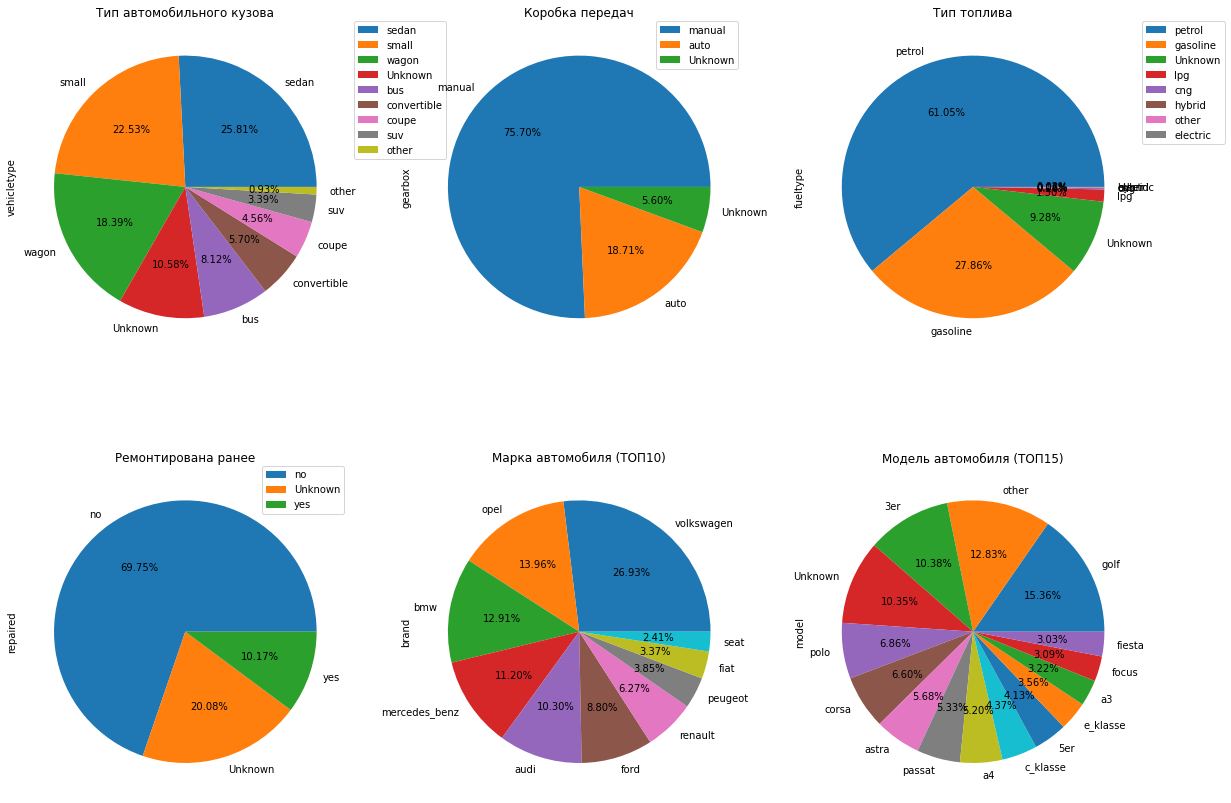

In [12]:
fig, ax = plt.subplots(2,3,figsize=(20, 15))
# fig.tight_layout() 

vehicletype_grouped =  data['vehicletype'].fillna('Unknown').to_frame()
vehicletype_grouped2 =(vehicletype_grouped['vehicletype'].value_counts(normalize=True)*100).sort_values(ascending=False)
vehicletype_grouped2.plot(kind='pie', autopct='%1.2f%%', ax = ax[0,0],legend=True)
ax[0,0].set_title('Тип автомобильного кузова')
ax[0,0].legend(bbox_to_anchor=(1, 1.02), loc='best')

gearbox_grouped =  data['gearbox'].fillna('Unknown').to_frame()
gearbox_grouped2 =(gearbox_grouped['gearbox'].value_counts(normalize=True)*100).sort_values(ascending=False)
gearbox_grouped2.plot(kind='pie', autopct='%1.2f%%', ax = ax[0,1],legend=True)
ax[0,1].set_title('Коробка передач')
ax[0,1].legend(bbox_to_anchor=(1, 1.02), loc='best')

fueltype_grouped =  data['fueltype'].fillna('Unknown').to_frame()
fueltype_grouped =(fueltype_grouped['fueltype'].value_counts(normalize=True)*100).sort_values(ascending=False)
fueltype_grouped.plot(kind='pie', autopct='%1.2f%%',  ax = ax[0,2],legend=True)
ax[0,2].set_title('Тип топлива')
ax[0,2].legend(bbox_to_anchor=(1, 1.02), loc='best')

repaired_grouped =  data['repaired'].fillna('Unknown').to_frame()
repaired_grouped =(repaired_grouped['repaired'].value_counts(normalize=True)*100).sort_values(ascending=False)
repaired_grouped.plot(kind='pie',  autopct='%1.2f%%', ax = ax[1,0],legend=True)
ax[1,0].set_title('Ремонтирована ранее')
ax[1,0].legend(bbox_to_anchor=(1, 1.02), loc='best')

brand_grouped =  data['brand'].fillna('Unknown').to_frame()
brand_grouped =(brand_grouped['brand'].value_counts(normalize=True)*100).sort_values(ascending=False).head(10)
brand_grouped.plot(kind='pie', autopct='%1.2f%%', ax=ax[1,1])
ax[1,1].set_title('Марка автомобиля (ТОП10)')

model_grouped =  data['model'].fillna('Unknown').to_frame()
model_grouped =(model_grouped['model'].value_counts(normalize=True)*100).sort_values(ascending=False).head(15)
model_grouped.plot(kind='pie', autopct='%1.2f%%', ax = ax[1,2])
ax[1,2].set_title('Модель автомобиля (ТОП15)')
plt.show()

**Тип кузова** наиболее популярными типами кузова являются - "sedan" (25.81%), "small"(22.53%) и "wagon" (18.39%)

**Коробка передач** МКПП (75.7%), АКПП (18.71%), остальные не указаны

**Тип топлива** Бензин (61.05%) и Газ (27.86%) - почти 89% значений, остальные типы топлива менее 11%

**Ремонта** наибольшее число анкет - не ремонтированные авто (69.75%), ремонтированных - 10.17%, остальные - неизвестные значения

**Марки авто** ТОП5 - Volkswagen (21.73%), Opel (11.27%), BMW (10.42%), Mercedes_benz (9.04%) и Audi (8.31%)

**Модель авто** ТОП5 - Volkswagen Golf - 15.36%, BMW Series 3 - 10.38%, Volkswagen Polo - 6.86%, Opel Corsa - 6.60%, Opel Astra - 5.68%. Кроме того, в 10.35% анкетах модель авто не указана, а в 12.83% - указана как "Другое"


In [13]:
# отберем только информативные столбцы

df_filtered = data[['price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'fueltype', 'brand',
       'repaired']]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   kilometer         354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
 9   repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


### Price

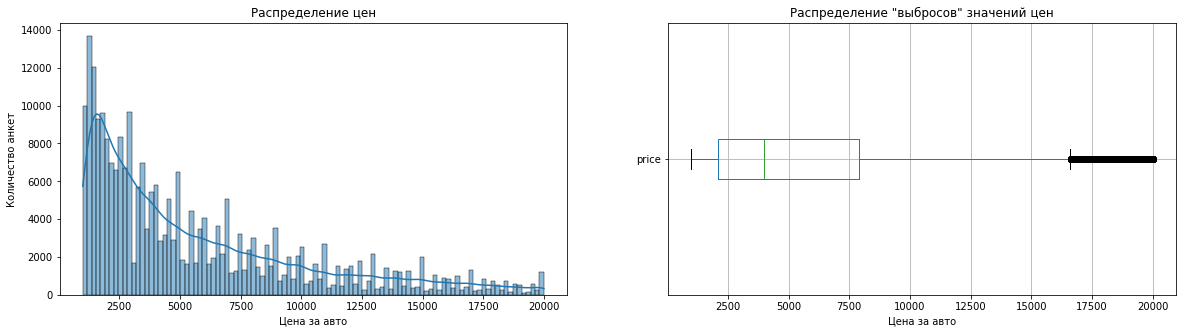

In [24]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot(kde=True, data=df_filtered, x="price",ax=ax[0])
ax[0].set_title('Распределение цен')
ax[0].set_xlabel('Цена за авто')
ax[0].set_ylabel('Количество анкет')

df_filtered.boxplot(column=['price'], vert=False, ax=ax[1])
ax[1].set_title('Распределение "выбросов" значений цен')
ax[1].set_xlabel('Цена за авто');

In [25]:

q1,q3 = np.percentile(df_filtered['price'], [25,75])
IQR = q3-q1
print('IQR', IQR)
print('q1', q1)
print('q3', q3)
lower_bound = 0
upper_bound = q3+3*IQR

print(lower_bound, upper_bound)

IQR 5800.0
q1 2100.0
q3 7900.0
0 25300.0


In [26]:
#  отсеиваем значения цены от 1 000 долларов
df_filtered = df_filtered.query('1000 <= price')

### Registrationyear

In [27]:
print('Максимальная дата скачивания анкеты -' , data['datecrawled'].max())
# отбираем период соответствующий действительному
df_filtered = df_filtered.query('1899 < registrationyear < 2017')
df_filtered['registrationyear'].describe()

Максимальная дата скачивания анкеты - 2016-04-07 14:36:58


count    255123.000000
mean       2004.183786
std           5.290699
min        1987.000000
25%        2001.000000
50%        2004.000000
75%        2008.000000
max        2016.000000
Name: registrationyear, dtype: float64

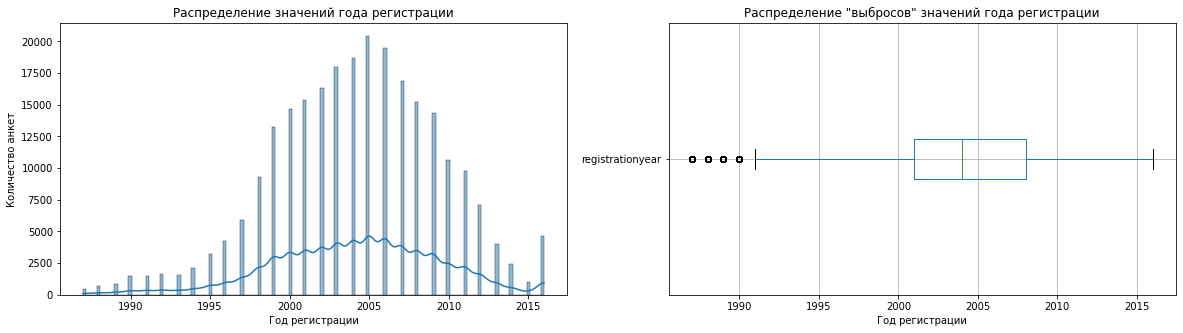

In [28]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot(kde=True, data=df_filtered, x="registrationyear",ax=ax[0])
ax[0].set_title('Распределение значений года регистрации')
ax[0].set_xlabel('Год регистрации');
ax[0].set_ylabel('Количество анкет')

df_filtered.boxplot(column=['registrationyear'], vert=False, ax=ax[1])
ax[1].set_title('Распределение "выбросов" значений года регистрации')
ax[1].set_xlabel('Год регистрации');


In [29]:
q1,q3 = np.percentile(df_filtered['registrationyear'], [25,75])
IQR = q3-q1
print('IQR', IQR)
print('q1', q1)
print('q3', q3)
lower_bound = q1-1.5*IQR
upper_bound = q3+1.5*IQR

print(lower_bound, upper_bound)
#3мкр убираем
df_filtered = df_filtered.query('1986 < registrationyear < 2020')
df_filtered['registrationyear'].describe()

IQR 7.0
q1 2001.0
q3 2008.0
1990.5 2018.5


count    255123.000000
mean       2004.183786
std           5.290699
min        1987.000000
25%        2001.000000
50%        2004.000000
75%        2008.000000
max        2016.000000
Name: registrationyear, dtype: float64

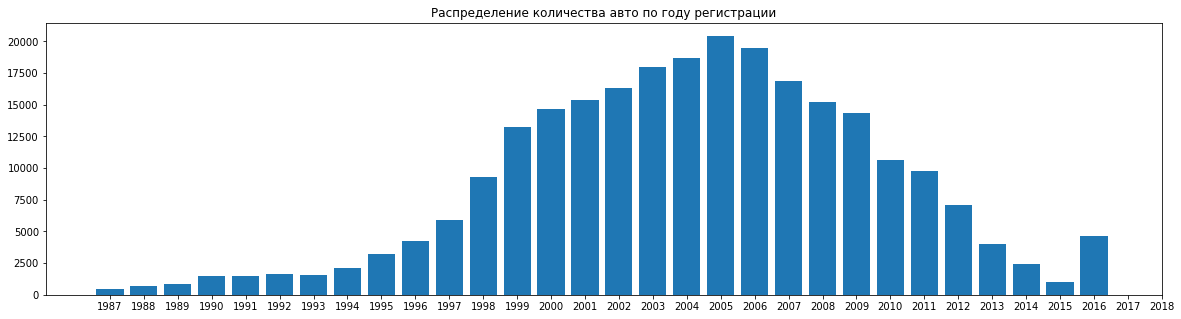

In [30]:
# количество авто по годам регистрации
fig,ax= plt.subplots(figsize=(20,5))
ax.bar(df_filtered["registrationyear"].value_counts().reset_index()['index'], df_filtered["registrationyear"].value_counts().reset_index()['registrationyear'])
ax.set_title('Распределение количества авто по году регистрации')
ax.set_xticks(np.arange(1987,2019,1));

### Power

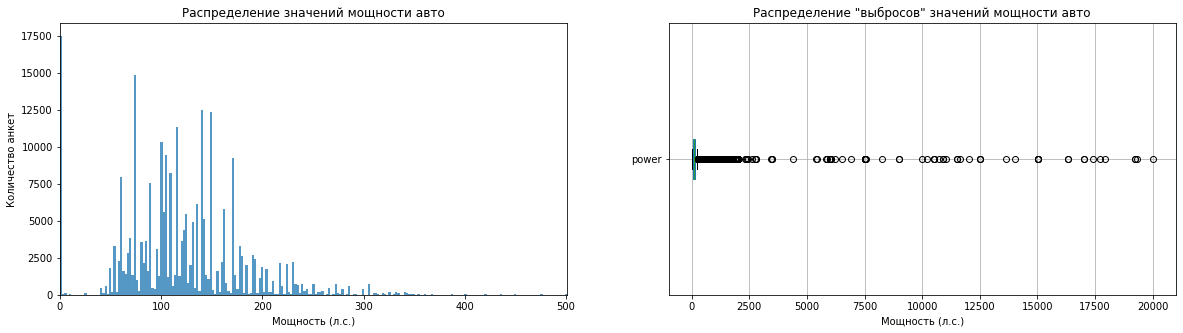

In [31]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

sns.histplot(data=df_filtered, x="power",ax=ax[0])
ax[0].set_title('Распределение значений мощности авто')
ax[0].set_xlabel('Мощность (л.с.)')
ax[0].set_ylabel('Количество анкет')
ax[0].set_xlim([0, 501])

df_filtered.boxplot(column=['power'], vert=False, ax=ax[1])
ax[1].set_title('Распределение "выбросов" значений мощности авто')
ax[1].set_xlabel('Мощность (л.с.)');



In [32]:
q1,q3 = np.percentile(df_filtered['power'], [25,75])
IQR = q3-q1
print('IQR', IQR)
print('q1', q1)
print('q3', q3)
lower_bound = q1-IQR
upper_bound = q3+3*IQR

print(lower_bound, upper_bound)
df_filtered = df_filtered.query('19 < power < 376')
df_filtered['power'].describe()

# минимальный порог был выбран 20 л.с., так как это минимум необходимый авто для поддержания движения
# максимум выбран из расчета 3 МКР

IQR 70.0
q1 80.0
q3 150.0
10.0 360.0


count    236696.000000
mean        128.158486
std          52.149562
min          20.000000
25%          90.000000
50%         120.000000
75%         150.000000
max         374.000000
Name: power, dtype: float64

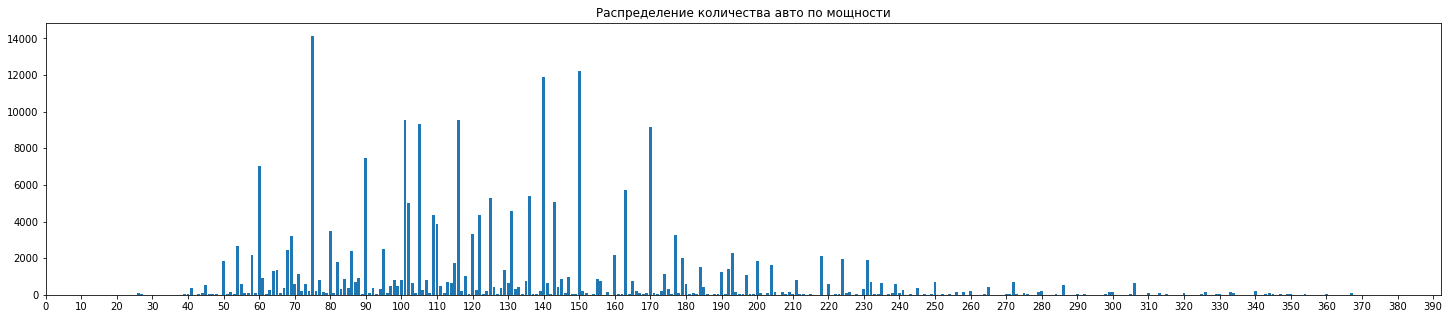

In [33]:
# количество авто по мощности
fig,ax= plt.subplots(figsize=(25,5))
ax.bar(df_filtered["power"].value_counts().reset_index()['index'], df_filtered["power"].value_counts().reset_index()['power'])
ax.set_title('Распределение количества авто по мощности')
ax.set_xticks(np.arange(0,400,10));


### Остальные

In [34]:
# заполнение пропусков медианным значением

df_filtered.fillna({'gearbox':'manual', 
                           'repaired':'no',
                           'model':'other'},
                          inplace=True)

In [35]:
%%time
# функция по заполнению пропусков - отбор по модели авто и заполнение значением моды
def filling_nan_column(df, model, column_nan):
    model_list = list(df[model].unique())
    column_nan_list = []
    for i in model_list:
        column_nan_list.append(list(df.loc[df.loc[:,model] == i][column_nan].mode())[0])
    model_dict = dict(zip(model_list, column_nan_list))
    
    for i in model_dict:
        df.loc[df.loc[:,model] == i] = df.loc[df.loc[:,model] == i].fillna(model_dict[i])
filling_nan_column(df_filtered, 'model', 'vehicletype')
filling_nan_column(df_filtered, 'model', 'fueltype')

CPU times: user 30.7 s, sys: 112 ms, total: 30.8 s
Wall time: 34.8 s


In [36]:
#  пропуски отсутствуют
df_filtered.isna().mean().sort_values(ascending=False)

price               0.0
vehicletype         0.0
registrationyear    0.0
gearbox             0.0
power               0.0
model               0.0
kilometer           0.0
fueltype            0.0
brand               0.0
repaired            0.0
dtype: float64

In [39]:
df_filtered

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...
354361,5250,wagon,2016,auto,150,159,150000,wagon,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [38]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236696 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             236696 non-null  int64 
 1   vehicletype       236696 non-null  object
 2   registrationyear  236696 non-null  int64 
 3   gearbox           236696 non-null  object
 4   power             236696 non-null  int64 
 5   model             236696 non-null  object
 6   kilometer         236696 non-null  int64 
 7   fueltype          236696 non-null  object
 8   brand             236696 non-null  object
 9   repaired          236696 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.9+ MB


**Вывод:**

Проанализированны предоставленные данные. Удалены аномальные значения и выбросы (около 37% от общих данных). Обработаны пропуски

## Обучение моделей

In [40]:
target = df_filtered['price']
features_0 = df_filtered.drop(['price'], axis=1)

In [41]:
# применяем one hot encoding 
features = pd.get_dummies(features_0, drop_first=True)
features.head()
# из 9 колонок получили 311

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
1,2011,190,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2008,69,90000,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
6,2004,109,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.33, random_state=12345)
print('features_train shape', features_train.shape)
print('features_test shape', features_test.shape)
print('target_train shape', target_train.shape)
print('target_test', target_test.shape)

features_train shape (148254, 311)
features_test shape (73022, 311)
target_train shape (148254,)
target_test (73022,)


In [ ]:
# масштабируем данные числовые
numeric = ['registrationyear', 'power', 'kilometer']
features_train_scaled = features_train.copy()
features_test_scaled = features_test.copy()
scaler = StandardScaler()
scaler.fit(features_train_scaled[numeric])
features_train_scaled[numeric] = scaler.transform(features_train_scaled[numeric])
features_test_scaled[numeric] = scaler.transform(features_test_scaled[numeric])

In [ ]:
# меняем диапазон значений от 0 до 1 (нормализация)
scaler = preprocessing.MinMaxScaler()
columns= features_train_scaled.columns
scaler.fit(features_train_scaled)
features_train_scaled_np = scaler.transform(features_train_scaled)
features_test_scaled_np = scaler.transform(features_test_scaled)
features_train_scaled_norm = pd.DataFrame(features_train_scaled_np, columns=columns)
features_test_scaled_norm = pd.DataFrame(features_test_scaled_np, columns=columns)


In [ ]:
%%time
# переводим float в int
features_train_scaled_norm[features_train_scaled_norm.columns[3:]] = features_train_scaled_norm[features_train_scaled_norm.columns[3:]].astype('int')
features_test_scaled_norm[features_test_scaled_norm.columns[3:]] = features_test_scaled_norm[features_test_scaled_norm.columns[3:]].astype('int')


CPU times: total: 43.2 s
Wall time: 43.7 s


In [ ]:
def rmse_scor (target, predictions):
    return (mean_squared_error(target,predictions))**0.5
    
rmse_score = make_scorer(rmse_scor, greater_is_better=False)


**Выбранные модели для обучения:**
Случайный лес, Линейная регрессия, LightGBM, CatBoostRegressor

### Линейная регрессия

In [ ]:
%%time
# применение модели линейной регрессии
model_linear = LinearRegression() 
 
print('linear_fit_ohe - ')
linear_fit_ohe = cross_val_score (model_linear,features_train,target_train, cv=5, scoring=rmse_score)
print(linear_fit_ohe.mean()*(-1))

print('linear_fit_scaled')
linear_fit_scaled = cross_val_score (model_linear,features_train_scaled,target_train, cv=5, scoring=rmse_score)
print(linear_fit_scaled.mean()*(-1))

print('linear_fit_scaled_norm')
linear_fit_scaled_norm = cross_val_score (model_linear,features_train_scaled_norm,target_train, cv=5, scoring=rmse_score)
print(linear_fit_scaled_norm.mean()*(-1))


linear_fit_ohe - 
2023.666709938704
linear_fit_scaled
2023.666709938616
linear_fit_scaled_norm
85433961918289.78
CPU times: total: 4min 11s
Wall time: 57.1 s


In [ ]:
df44 = pd.DataFrame(data = [linear_fit_ohe,linear_fit_scaled,linear_fit_scaled_norm]).T
df44.rename(columns={0:'linear_fit_ohe',1:'linear_fit_scaled',2:'linear_fit_scaled_norm'})
df44.style.format("{:,.2f}") 


,0,1,2
0,"-2,014.59","-2,014.59","-34,648,078,894.16"
1,"-2,023.34","-2,023.34","-14,305,397,140,681.19"
2,"-2,024.54","-2,024.54","-395,781,346,165,351.31"
3,"-2,032.37","-2,032.37","-17,048,418,204,497.13"
4,"-2,023.50","-2,023.50","-2,025.12"


Нормализация признаков ухудшает модель.

Значения метрики качества модели для отмасштабированных признаков и нет - схожи

### Случайный лес

In [ ]:
%%time
# применение GridSearchCV на немасштабированных выборках
parametrs = {  'n_estimators': range(1, 16, 5),
             'max_depth': range(1, 6, 2),
              'min_samples_leaf': range(1,4),
              'min_samples_split': range(2,6,2),
            }
model = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(model, parametrs, cv= 5, n_jobs=-1, scoring=rmse_score)
grid.fit(features_train,target_train)

CPU times: total: 17.9 s
Wall time: 6min 35s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 6, 2),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(1, 16, 5)},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', grid.best_params_)
print("Score -", grid.score(features_train, target_train) * (-1))
print('Время обучения лучшей модели', grid.cv_results_['mean_fit_time'][grid.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 11}
Score - 1967.8443369178326
Время обучения лучшей модели 30.25585308074951


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', grid.best_score_*(-1))
print('Время предсказания -', grid.cv_results_['mean_score_time'][grid.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качества модели - 1966.3719105319353
Время предсказания - 0.11789803504943848


In [ ]:
%%time
# применение GridSearchCV на немасштабированных выборках
parametrs = {  'n_estimators': range(1, 16, 5),
             'max_depth': range(1, 6, 2),
              'min_samples_leaf': range(1,4),
              'min_samples_split': range(2,6,2),
            }
model = RandomForestRegressor(random_state=12345)
grid_scaled = GridSearchCV(model, parametrs, cv= 5, n_jobs=-1, scoring=rmse_score)
grid_scaled.fit(features_train_scaled,target_train)

CPU times: total: 18.6 s
Wall time: 6min 45s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 6, 2),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(1, 16, 5)},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', grid_scaled.best_params_)
print("Score -", grid_scaled.score(features_train_scaled, target_train) * (-1))
print('Время обучения лучшей модели', grid_scaled.cv_results_['mean_fit_time'][grid_scaled.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 11}
Score - 1967.844178460365
Время обучения лучшей модели 29.859619474411012


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', grid_scaled.best_score_*(-1))
print('Время предсказания -', grid_scaled.cv_results_['mean_score_time'][grid_scaled.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качества модели - 1966.371918793288
Время предсказания - 0.12597689628601075


In [ ]:
%%time
# применение GridSearchCV на немасштабированных выборках
parametrs = {  'n_estimators': range(1, 16, 5),
             'max_depth': range(1, 6, 2),
              'min_samples_leaf': range(1,4),
              'min_samples_split': range(2,6,2),
            }
model = RandomForestRegressor(random_state=12345)
grid_scaled_norm = GridSearchCV(model, parametrs, cv= 5, n_jobs=-1, scoring=rmse_score)
grid_scaled_norm.fit(features_train_scaled_norm,target_train)

CPU times: total: 18.4 s
Wall time: 6min 58s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 6, 2),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 6, 2),
                         'n_estimators': range(1, 16, 5)},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', grid_scaled_norm.best_params_)
print("Score -", grid_scaled_norm.score(features_train_scaled_norm, target_train) * (-1))
print('Время обучения лучшей модели', grid_scaled_norm.cv_results_['mean_fit_time'][grid_scaled_norm.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 11}
Score - 1967.8443369178326
Время обучения лучшей модели 31.617050695419312


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', grid_scaled_norm.best_score_*(-1))
print('Время предсказания -', grid_scaled_norm.cv_results_['mean_score_time'][grid_scaled_norm.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качетсва модели - 1966.374761002719
Время предсказания - 0.1375420570373535


**Вывод:**

Модели случайного леса показали одинаковые значения качества модели - 1966.37, время предсказания лучшей модели - 7 сек 


### LGBMRegressor

In [ ]:
%%time

lgb_model = lgb.LGBMRegressor(random_state=12345)

lgb_parametrs = {"max_depth": [10, 50, 100],
               "num_leaves": [500, 1200],
               "n_estimators": range (5, 16, 5)
             }
#Применяю GridSearchCV с кросс-валидацией
lgb_grid = GridSearchCV(lgb_model, lgb_parametrs, scoring=rmse_score, cv=5)
lgb_grid.fit(features_train, target_train)

CPU times: total: 12min 16s
Wall time: 2min 44s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': [10, 50, 100],
                         'n_estimators': range(5, 16, 5),
                         'num_leaves': [500, 1200]},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', lgb_grid.best_params_)
print("Score -", lgb_grid.score(features_train, target_train) * (-1))
print('Время обучения лучшей модели', lgb_grid.cv_results_['mean_fit_time'][lgb_grid.cv_results_['rank_test_score'] == 1][0])
print('Mean_test_score', lgb_grid.cv_results_['mean_test_score'][lgb_grid.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'max_depth': 50, 'n_estimators': 15, 'num_leaves': 1200}
Score - 1489.1475023078501
Время обучения лучшей модели 2.479554796218872
Mean_test_score -1565.9734837027822


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', lgb_grid.best_score_*(-1))
print('Время предсказания -', lgb_grid.cv_results_['mean_score_time'][lgb_grid.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качества модели - 1565.9734837027822
Время предсказания - 0.18626780509948732


In [ ]:
%%time

lgb_model = lgb.LGBMRegressor(random_state=12345)

lgb_parametrs = {"max_depth": [10, 50, 100],
               "num_leaves": [500, 1200],
               "n_estimators": range (5, 16, 5)
             }
#Применяю GridSearchCV с кросс-валидацией
lgb_grid_scaled = GridSearchCV(lgb_model, lgb_parametrs, scoring=rmse_score, cv=5)
lgb_grid_scaled.fit(features_train_scaled, target_train)

CPU times: total: 12min 32s
Wall time: 2min 33s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': [10, 50, 100],
                         'n_estimators': range(5, 16, 5),
                         'num_leaves': [500, 1200]},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', lgb_grid_scaled.best_params_)
print("Score -", lgb_grid_scaled.score(features_train_scaled, target_train) * (-1))
print('Время обучения лучшей модели', lgb_grid_scaled.cv_results_['mean_fit_time'][lgb_grid_scaled.cv_results_['rank_test_score'] == 1][0])
print('Mean_test_score', lgb_grid_scaled.cv_results_['mean_test_score'][lgb_grid_scaled.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'max_depth': 50, 'n_estimators': 15, 'num_leaves': 1200}
Score - 1488.9398417657046
Время обучения лучшей модели 2.215584564208984
Mean_test_score -1566.1447654463516


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', lgb_grid_scaled.best_score_*(-1))
print('Время предсказания -', lgb_grid_scaled.cv_results_['mean_score_time'][lgb_grid_scaled.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качества модели - 1566.1447654463516
Время предсказания - 0.15942029953002929


In [ ]:
%%time

lgb_model = lgb.LGBMRegressor(random_state=12345)

lgb_parametrs = {"max_depth": [10, 50, 100],
               "num_leaves": [500, 1200],
               "n_estimators": range (5, 16, 5)
             }
#Применяю GridSearchCV с кросс-валидацией
lgb_grid_scaled_norm = GridSearchCV(lgb_model, lgb_parametrs, scoring=rmse_score, cv=5)
lgb_grid_scaled_norm.fit(features_train_scaled_norm, target_train)

CPU times: total: 12min 34s
Wall time: 2min 34s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=12345),
             param_grid={'max_depth': [10, 50, 100],
                         'n_estimators': range(5, 16, 5),
                         'num_leaves': [500, 1200]},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', lgb_grid_scaled_norm.best_params_)
print("Score -", lgb_grid_scaled_norm.score(features_train_scaled_norm, target_train) * (-1))
print('Время обучения лучшей модели', lgb_grid_scaled_norm.cv_results_['mean_fit_time'][lgb_grid_scaled_norm.cv_results_['rank_test_score'] == 1][0])
print('Mean_test_score', lgb_grid_scaled_norm.cv_results_['mean_test_score'][lgb_grid_scaled_norm.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'max_depth': 50, 'n_estimators': 15, 'num_leaves': 1200}
Score - 1489.1475023078501
Время обучения лучшей модели 2.071344327926636
Mean_test_score -1565.813847202962


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', lgb_grid_scaled_norm.best_score_*(-1))
print('Время предсказания -', lgb_grid_scaled_norm.cv_results_['mean_score_time'][lgb_grid_scaled_norm.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качества модели - 1565.813847202962
Время предсказания - 0.17817225456237792


**Вывод:**

Модель LGBMRegressor - наилучшее значение качества - 1565.81 - незначительно отличается от соседних моделей - получено на масштабированных и нормализованных данных, а так же на чистых. Время обучения модели - 0.178 сек 


### CatBoostRegressor

In [ ]:
%%time

cb_model = cb.CatBoostRegressor(random_state=12345)

cb_parametrs = {'iterations': [200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8]
         }
cb_grid = GridSearchCV(cb_model, cb_parametrs, scoring=rmse_score, cv=5)
cb_grid.fit(features_train, target_train)

0:	learn: 3383.6088223	total: 159ms	remaining: 31.6s
1:	learn: 3340.4130367	total: 169ms	remaining: 16.7s
2:	learn: 3298.2940577	total: 179ms	remaining: 11.8s
3:	learn: 3258.1705415	total: 190ms	remaining: 9.31s
4:	learn: 3219.5381070	total: 200ms	remaining: 7.78s
5:	learn: 3182.9418914	total: 209ms	remaining: 6.75s
6:	learn: 3147.4780747	total: 219ms	remaining: 6.03s
7:	learn: 3112.6314967	total: 229ms	remaining: 5.49s
8:	learn: 3080.5042849	total: 240ms	remaining: 5.08s
9:	learn: 3049.1379352	total: 250ms	remaining: 4.74s
10:	learn: 3018.0522388	total: 259ms	remaining: 4.45s
11:	learn: 2989.4639529	total: 269ms	remaining: 4.22s
12:	learn: 2960.9277967	total: 278ms	remaining: 4s
13:	learn: 2932.7611113	total: 288ms	remaining: 3.82s
14:	learn: 2906.0096032	total: 296ms	remaining: 3.65s
15:	learn: 2881.1346306	total: 307ms	remaining: 3.53s
16:	learn: 2856.4289841	total: 316ms	remaining: 3.4s
17:	learn: 2833.2274851	total: 325ms	remaining: 3.29s
18:	learn: 2811.2317303	total: 335ms	remai

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001AF82321400>,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [200],
                         'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', cb_grid.best_params_)
print("Score -", cb_grid.score(features_train, target_train) * (-1))
print('Время обучения лучшей модели', cb_grid.cv_results_['mean_fit_time'][cb_grid.cv_results_['rank_test_score'] == 1][0])
print('Mean_test_score', cb_grid.cv_results_['mean_test_score'][cb_grid.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Score - 1395.5968650163854
Время обучения лучшей модели 6.001609802246094
Mean_test_score -1415.6078725862467


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', cb_grid.best_score_*(-1))
print('Время предсказания -', cb_grid.cv_results_['mean_score_time'][cb_grid.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качества модели - 1415.6078725862467
Время предсказания - 0.04528927803039551


In [ ]:
%%time

cb_model = cb.CatBoostRegressor(random_state=12345)

cb_parametrs = {'iterations': [200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8]
         }
cb_grid_scaled = GridSearchCV(cb_model, cb_parametrs, scoring=rmse_score, cv=5)
cb_grid_scaled.fit(features_train_scaled, target_train)

0:	learn: 3383.6088223	total: 22.3ms	remaining: 4.44s
1:	learn: 3340.4130367	total: 30.3ms	remaining: 3s
2:	learn: 3298.2940577	total: 38.2ms	remaining: 2.51s
3:	learn: 3258.1705415	total: 46.1ms	remaining: 2.26s
4:	learn: 3219.5381070	total: 53.9ms	remaining: 2.1s
5:	learn: 3182.9418914	total: 61.2ms	remaining: 1.98s
6:	learn: 3147.4780747	total: 69.3ms	remaining: 1.91s
7:	learn: 3112.6314967	total: 77.3ms	remaining: 1.85s
8:	learn: 3080.5042849	total: 86.4ms	remaining: 1.83s
9:	learn: 3049.1379352	total: 95.6ms	remaining: 1.81s
10:	learn: 3018.0522388	total: 104ms	remaining: 1.78s
11:	learn: 2989.4639529	total: 112ms	remaining: 1.75s
12:	learn: 2960.9277967	total: 119ms	remaining: 1.72s
13:	learn: 2932.7611113	total: 127ms	remaining: 1.68s
14:	learn: 2906.0096032	total: 134ms	remaining: 1.65s
15:	learn: 2881.1346306	total: 142ms	remaining: 1.63s
16:	learn: 2856.4289841	total: 149ms	remaining: 1.6s
17:	learn: 2833.2274851	total: 156ms	remaining: 1.58s
18:	learn: 2811.2317303	total: 16

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001AF8B5F7E80>,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [200],
                         'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', cb_grid_scaled.best_params_)
print("Score -", cb_grid_scaled.score(features_train_scaled, target_train) * (-1))
print('Время обучения лучшей модели', cb_grid_scaled.cv_results_['mean_fit_time'][cb_grid_scaled.cv_results_['rank_test_score'] == 1][0])
print('Mean_test_score', cb_grid_scaled.cv_results_['mean_test_score'][cb_grid_scaled.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Score - 1395.5968650163854
Время обучения лучшей модели 5.724217510223388
Mean_test_score -1415.6078725862467


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', cb_grid_scaled.best_score_*(-1))
print('Время предсказания -', cb_grid_scaled.cv_results_['mean_score_time'][cb_grid_scaled.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качества модели - 1415.6078725862467
Время предсказания - 0.04349827766418457


In [ ]:
%%time

cb_model = cb.CatBoostRegressor(random_state=12345)

cb_parametrs = {'iterations': [200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8]
         }
cb_grid_scaled_norm = GridSearchCV(cb_model, cb_parametrs, scoring=rmse_score, cv=5)
cb_grid_scaled_norm.fit(features_train_scaled_norm, target_train)

0:	learn: 3383.6088223	total: 14.2ms	remaining: 2.83s
1:	learn: 3340.4130367	total: 23.5ms	remaining: 2.32s
2:	learn: 3298.2940577	total: 32.9ms	remaining: 2.16s
3:	learn: 3258.1705415	total: 42.1ms	remaining: 2.06s
4:	learn: 3219.5381070	total: 51.4ms	remaining: 2s
5:	learn: 3182.9418914	total: 60.4ms	remaining: 1.95s
6:	learn: 3147.4780747	total: 69.8ms	remaining: 1.93s
7:	learn: 3112.6314967	total: 78.8ms	remaining: 1.89s
8:	learn: 3080.5042849	total: 87.8ms	remaining: 1.86s
9:	learn: 3049.1379352	total: 96.6ms	remaining: 1.83s
10:	learn: 3018.0522388	total: 105ms	remaining: 1.8s
11:	learn: 2989.4639529	total: 113ms	remaining: 1.77s
12:	learn: 2960.9277967	total: 121ms	remaining: 1.73s
13:	learn: 2932.7611113	total: 128ms	remaining: 1.7s
14:	learn: 2906.0096032	total: 136ms	remaining: 1.68s
15:	learn: 2881.1346306	total: 144ms	remaining: 1.66s
16:	learn: 2856.4289841	total: 154ms	remaining: 1.65s
17:	learn: 2833.2274851	total: 162ms	remaining: 1.64s
18:	learn: 2811.2317303	total: 17

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001AF86341AC0>,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [200],
                         'learning_rate': [0.03, 0.1]},
             scoring=make_scorer(rmse_scor, greater_is_better=False))

In [ ]:
print('Параметры наилучшей модели -', cb_grid_scaled_norm.best_params_)
print("Score -", cb_grid_scaled_norm.score(features_train_scaled_norm, target_train) * (-1))
print('Время обучения лучшей модели', cb_grid_scaled_norm.cv_results_['mean_fit_time'][cb_grid_scaled_norm.cv_results_['rank_test_score'] == 1][0])
print('Mean_test_score', cb_grid_scaled_norm.cv_results_['mean_test_score'][cb_grid_scaled_norm.cv_results_['rank_test_score'] == 1][0])

Параметры наилучшей модели - {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Score - 1395.5968650163854
Время обучения лучшей модели 5.8361071109771725
Mean_test_score -1415.6078725862467


In [ ]:
# best_score_ и mean_score_time
print('Наилучшее значение качества модели -', cb_grid_scaled_norm.best_score_*(-1))
print('Время предсказания -', cb_grid_scaled_norm.cv_results_['mean_score_time'][cb_grid_scaled_norm.cv_results_['rank_test_score'] == 1].min())

Наилучшее значение качества модели - 1415.6078725862467
Время предсказания - 0.037007379531860354


**Вывод:**

Наилучшее значение качества для CatBoostRegressor 1415.6 - одинаково для нормализованных, масштабированных и чистых данных. Время обучения модели - 0.037 сек - огромная разница с предыдущими моделями


## Анализ моделей

In [ ]:
%%time
# проверка на тестовых данных
cb_grid = cb.CatBoostRegressor(depth= 8, iterations= 200, learning_rate= 0.1, random_state=12345)
cb_grid.fit(features_train, target_train)
prediction_cb_test = cb_grid.predict(features_test)

0:	learn: 3211.8421919	total: 34.8ms	remaining: 6.93s
1:	learn: 3019.6439082	total: 62.5ms	remaining: 6.19s
2:	learn: 2854.0408536	total: 89.8ms	remaining: 5.89s
3:	learn: 2707.6912278	total: 119ms	remaining: 5.81s
4:	learn: 2581.2583285	total: 151ms	remaining: 5.9s
5:	learn: 2469.7164222	total: 180ms	remaining: 5.82s
6:	learn: 2370.4800015	total: 211ms	remaining: 5.81s
7:	learn: 2284.6898429	total: 254ms	remaining: 6.09s
8:	learn: 2209.1840378	total: 291ms	remaining: 6.17s
9:	learn: 2145.2957823	total: 322ms	remaining: 6.12s
10:	learn: 2087.3018923	total: 352ms	remaining: 6.04s
11:	learn: 2038.6275222	total: 380ms	remaining: 5.95s
12:	learn: 1994.4272123	total: 409ms	remaining: 5.88s
13:	learn: 1953.5274028	total: 435ms	remaining: 5.78s
14:	learn: 1915.5036123	total: 462ms	remaining: 5.7s
15:	learn: 1884.0547286	total: 489ms	remaining: 5.63s
16:	learn: 1857.8738186	total: 518ms	remaining: 5.58s
17:	learn: 1831.9430530	total: 549ms	remaining: 5.55s
18:	learn: 1810.6616243	total: 575ms	

In [ ]:
print('RMSE -', (mean_squared_error(target_test, prediction_cb_test))**0.5)
print('Время выполнения -', 6.24, "сек")

RMSE - 1413.4438741665958
Время выполнения - 6.24 сек


**Проверка на адекватность**

In [ ]:
from sklearn.dummy import DummyRegressor

rfm_dummy = DummyRegressor( strategy='median') 

rfm_dummy.fit(features_train,target_train)
rfm_pred = rfm_dummy.predict(target_test)
rmse = (mean_squared_error(target_test, rfm_pred))**0.5
print("Точность модели с использованием DummyRegressor -", rmse)

Точность модели с использованием DummyRegressor - 3565.8044063949224


Проверка модели на адекватность - если в предсказании будет записана наиболее популярная цена (most_frequent), то ошибка модели 3565,8 евро

## Общий итог

На этапе подготовки данных был получен датасет из 16 столбцов и 354369 строк. После чего данные были обработаны - пропуски были заменены значением моды, удалены выбросы, а также были визуализированны данные.

На втором этапе датасет был нормализован и отмасштабирован, а затем поделен на тестовую и обучающую выборку (итого 3 вида данных для обучения и теста - чистые (нечисловые данные переведены в категориальные - (0 и 1)), отмасштабированные, и масштабирование +нормализация). После чего произошло обучение 4 моделей и определены оптимальные гиперпараметры и показатели метрики RMSE на кросс-валидации. В качестве моделей использованы Линейная регрессия, Случайный лес, LGBMRegressor, CatBoostRegressor.

На этапе Анализа моделей было произведено предсказание на тестовой выборке модели с наилучшими гиперпараметрами и показавшей наилучшие значения качества приобучении. Такой моделью стала CatBoostRegressor с гиперпараметрами (depth= 8, iterations= 200, learning_rate= 0.1) и значением качества на тренировочной выборке - 1415.61 и временем обучения 0.037 сек. На тестовых данных модель показала себя немного лучше - RMSE=1413.44, время выполнения - 6.22 сек

Для константной модели RMSE=3565.8 евро. Модель прошла тест на адекватность.

Для работы рекомендуется применять модель на основе CatBoostRegressor.